In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from aegomoku.gomoku_game import ConstantBoardInitializer, GomokuGame
from aegomoku.arena import Arena
from aegomoku.interfaces import MctsParams, PolicyParams
from aegomoku.gomoku_players import PolicyAdvisedGraphSearchPlayer
from pathlib import Path

In [7]:
from aegomoku.gomoku_game import RandomBoardInitializer

BOARD_SIZE = 19
initializer = RandomBoardInitializer(BOARD_SIZE, 2, 9, 11, 9, 11)
#initializer = TopoSwap2BoardInitializer(BOARD_SIZE)
#initializer = ConstantBoardInitializer("H10")
the_game = GomokuGame(board_size=BOARD_SIZE, initializer=initializer)

model_file = Path.home() / "workspace" / "Project-Ellie" / "DATA" / 'models' / '2_c1.model'
mcts_champion = MctsParams(cpuct=1.0, temperature=0, num_simulations=400)
policy_champion = PolicyParams(model_file_name=model_file, advice_cutoff=.01)
player1 = PolicyAdvisedGraphSearchPlayer("Champion 2_c1", the_game, mcts_champion, policy_champion)

model_file = Path.home() / "workspace" / "Project-Ellie" / "DATA" / 'models' / '3_c2.model'
mcts_challenger = MctsParams(cpuct=1.0, temperature=0, num_simulations=400)
policy_challenger = PolicyParams(model_file_name=model_file, advice_cutoff=.01)
player2 = PolicyAdvisedGraphSearchPlayer("Candidate 3_c2", the_game, mcts_challenger, policy_challenger)

arena = Arena(game=the_game, player1=player1, player2=player2, max_moves=100)

In [17]:
arena.play_game(verbose=2)

Champion 2_c1 to begin with black.
1: Champion 2_c1: K7
2: Candidate 3_c2: J7
3: Champion 2_c1: L8
4: Candidate 3_c2: N10
5: Champion 2_c1: J6
6: Candidate 3_c2: I5
7: Champion 2_c1: M10
8: Candidate 3_c2: L9
9: Champion 2_c1: M8
10: Candidate 3_c2: I6
11: Champion 2_c1: H5
12: Candidate 3_c2: M7
13: Champion 2_c1: N9
14: Candidate 3_c2: K6
15: Champion 2_c1: O10
16: Candidate 3_c2: P11
17: Champion 2_c1: M11
18: Candidate 3_c2: M12
19: Champion 2_c1: L11
20: Candidate 3_c2: O8
21: Champion 2_c1: K12
22: Candidate 3_c2: J13
23: Champion 2_c1: J11
24: Candidate 3_c2: K11
25: Champion 2_c1: L13
26: Candidate 3_c2: I10
27: Champion 2_c1: L12
28: Candidate 3_c2: L14
29: Champion 2_c1: I8
30: Candidate 3_c2: M14
31: Champion 2_c1: L6
32: Candidate 3_c2: L5
33: Champion 2_c1: M5
34: Candidate 3_c2: J8
35: Champion 2_c1: N4
36: Candidate 3_c2: O3
37: Champion 2_c1: N3
38: Candidate 3_c2: K14
39: Champion 2_c1: J14
40: Candidate 3_c2: N14
41: Champion 2_c1: O14
42: Candidate 3_c2: I12
43: Cham

Champion 2_c1

# TODO: Arena needs to respect the gamestate

In [18]:
arena.board.plot()

                                                                 
19    .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .    
18    .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .    
17    .  .  .  .  .  .  .  .  .  X  .  .  .  .  .  .  .  .  .    
16    .  .  .  .  .  .  .  .  .  .  O  .  X  .  .  .  .  .  .    
15    .  .  .  .  .  .  .  .  O  O  O  O  .  O  .  .  .  .  .    
14    .  .  .  .  .  .  .  .  .  X  O  O  O  O  X  .  .  .  .    
13    .  .  .  .  .  .  .  .  .  O  X  X  .  O  O  .  .  .  .    
12    .  .  .  .  .  .  .  .  O  .  X  X  O  X  X  .  .  .  .    
11    .  .  .  .  .  .  .  X  .  X  O  X  X  .  .  O  .  .  .    
10    .  .  .  .  .  .  .  .  O  .  O  .  X  O  X  .  .  .  .    
 9    .  .  .  .  .  .  .  .  .  .  .  O  X  X  .  .  .  .  .    
 8    .  .  .  .  .  .  .  .  X  O  O  X  X  .  O  .  .  .  .    
 7    .  .  .  .  .  .  .  .  .  O  X  X  O [X] .  .  .  .  .    
 6    .  .  .  .  .  .  .  .  O  X  O  X  .  X  .  .  .  .  .    
 5    .  .

In [19]:
from aegomoku.tools import stones_to_string
stones = arena.board.get_stones()
stones = stones_to_string(stones)

In [20]:
from cmclient.api.study import StudyHandler
from cmclient.api.basics import CompManConfig

config = CompManConfig(board_size=19)
initializer = ConstantBoardInitializer(stones)
# initializer = TopoSwap2BoardInitializer(config.board_size)
ai = "../DATA/models/3_c2.model"
num_simulations = 400
StudyHandler(config, "../cmclient/gui/", initializer, ai, num_simu=num_simulations).handle()

pygame 2.1.2 (SDL 2.0.16, Python 3.8.10)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [8]:
from pathlib import Path
arena_file = Path.home() / "workspace" / "Project-Ellie" / "DATA" / 'arena' / '3_c2.arena'

In [9]:
stats = arena.play_games(40, verbose=1, save_to=arena_file)

Game 1: Champion 2_c1 to begin with black.
Champion 2_c1 (black) won.
[J8, K10, K7, H10, M5, L6, K8, L9, K5, K6, L5, M8, J5, N5, I5]
Game 2: Champion 2_c1 to begin with black.
Candidate 3_c2 (black) won.
[J8, K8, K7, J9, I9, H10, L7, J7, L6, M5, L9, L8, M8, I10, K6, N9, J5, I4, J6, I6, N6, M6, N7, K10, O6, P5, J10, H11, G12, L11, M7, O7, M12, M10, K12, H5, G4, I8, H7, H12, L12, H13, N12, H14]
Game 3: Champion 2_c1 to begin with black.
Candidate 3_c2 (black) won.
[L10, L9, M9, K11, M10, K10, M8, M11, M7, M6, N8, L11, O7, P6, J11, M12, J9, N13, O14, K12, K13, N11, O11, O10, L13, N12, N10, L12, J12, O12]
Game 4: Champion 2_c1 to begin with black.
Champion 2_c1 (black) won.
[L10, K8, N8, M9, N10, M10, M11, L9, N11, J7, I6, N9, K9, O9, P9, N12, O10, M12, L11, O11, Q8, R7, O8, M8, J11, K11, P8, R8, P10, P7, Q10, R10, R11, N7, S12]
Game 5: Champion 2_c1 to begin with black.
Champion 2_c1 (black) won.
[K9, L9, L8, K10, J10, M7, J11, J9, I11, H12, H11, G11, L11, K11, I13, I12, J12, J13, K13, L1

In [10]:
stats

{Champion 2_c1: 16, Candidate 3_c2: 24, 'draws': 0}

In [16]:
from pickle import Pickler

with open('3_c2.arena', 'wb+') as f:
    Pickler(f).dump(arena.games)

In [33]:
n=0

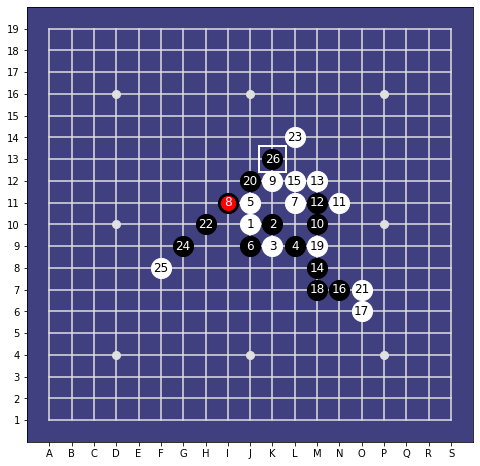

In [57]:
from aegomoku.policies.heuristic_policy import HeuristicPolicy
from aegomoku.utils import analyse_board
moves = arena.board.stones
heuristics = HeuristicPolicy(BOARD_SIZE, cut_off=0.1)
analyse_board(BOARD_SIZE, arena.games[n], heuristics, disp_width=8)
n += 1